In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz

import main
import fsgif_model as fsgif

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
Ahist = Series.from_raw(io.loadraw("I-sin_mf_raw.dat"))
Ihist = Series.from_raw(io.loadraw("I-sin_input_raw.dat"))

In [3]:
model_params, memory_time = main.get_params()
mfmodel = fsgif.GIF_mean_field(model_params, Ahist, Ihist)

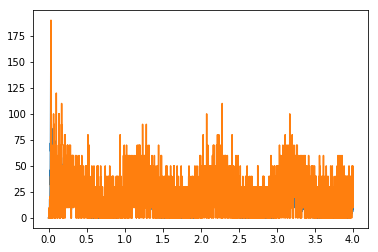

In [4]:
anlz.plot(Ahist)

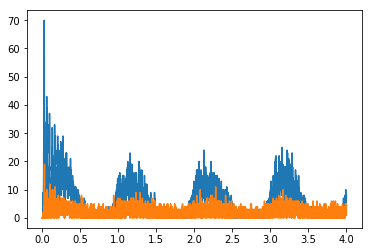

In [5]:
anlz.plot(mfmodel.n)

In [6]:
mfmodel.loglikelihood(1.0, 3.0)

ShimmedShared(-5942564.490928166)

In [ ]:
%debug

> /home/rene/Recherche/macke_lab/code/theano_shim/theano_shim/core.py(1085)log()
   1083     if is_theano_object(x):
   1084         return T.log(x)
-> 1085     else:
   1086         return np.log(x)
   1087 def log10(x):

ipdb> up
> /home/rene/Recherche/macke_lab/code/sinn/sinn/models/common.py(315)loglikelihood()
    313                 l = shim.sum( -shim.log(shim.factorial(n_arr, exact=True))
    314                               -(N-n_arr)*shim.log(N - n_arr) + N-n_arr + n_arr*shim.log(p_arr)
--> 315                               + (N-n_arr)*shim.log(1-p_arr) )
    316                     # with exact=True, factorial is computed only once for whole array
    317             else:

ipdb> shim.isshared(n_arr)
False
ipdb> shim.cf._Terminating_types
*** AttributeError: module 'theano_shim.config' has no attribute '_Terminating_types'
ipdb> shim.cf._TerminatingTypes
(<class 'scipy.sparse.base.spmatrix'>, <class 'theano_shim.core.ShimmedShared'>, <class 'str'>)
ipdb> break 365
End of fi

In [7]:
model_params.t_ref

(0.004, 0.004)